# Setting the values for constants
* inf: as a default distance to nodes
* time_threshold: threshold time for the rebuilding of the quantum link
* original_capacity: original capacity of the quantum link
* original_cost: cost of using the link
* Edge: create Edge object of the graph

In [62]:
inf = float('inf')
time_threshold = 10000
original_capacity = 4
original_cost = 1
rebuild_probability = 0.25
number_of_nodes = 32

In [63]:
# Importing packages
import os
from collections import deque, namedtuple
import time, random, logging, logging.handlers
from datetime import datetime

# Setting up logging
logging.basicConfig(filename='dijkstra.log',level=logging.DEBUG,
                    filemode='w')

# The Graph class

In [64]:
# Edge object of a graph
Edge = namedtuple('edge', 'start, end, cost, capacity')

# Method adding an edge in the graph
def make_edge(start, end, cost=original_cost, capacity=original_capacity):
    return Edge(start, end, cost, capacity)

def make_backward_edge(start, end, cost=original_cost, capacity=original_capacity):
    return Edge(end, start, cost, capacity)

def dist(graph, start_node, end_node):
    return min(abs(start_node - end_node), len(graph.vertices) + start_node - end_node,
               abs(end_node - start_node), len(graph.vertices) - start_node + end_node)

In [65]:
class Graph:

    # Check that the arguments are valid
    def __init__(self, edges):
        wrong_edges = [i for i in edges if len(i) not in [2, 4]]
        if wrong_edges:
            raise ValueError('Wrong edges data: %s', wrong_edges)

        self.edges = [ make_edge(*Edge) for Edge in edges] + [make_backward_edge(*edge) for edge in edges]

    # Properties of the class
    @property
    def vertices(self):
        return set(
            sum(
                ([this_edge.start, this_edge.end] for this_edge in self.edges), []
            )
        )

    @property
    def neighbours(self):
        neighbours = {vertex: set() for vertex in self.vertices}
        for this_edge in self.edges:
            neighbours[this_edge.start].add((this_edge.end, this_edge.cost))

        return neighbours

    # Get current capacity of a specific link
    def link_capacity(self, startNode, endNode):

        # Assembling node pairs into a list
        node_pairs = [[startNode, endNode], [endNode, startNode]]
        edges = self.edges[:]
        for this_edge in edges:
            if [this_edge.start, this_edge.end] in node_pairs:
                return this_edge.capacity
    
    # Adds a link to the network specified by a pair of nodes, the cost and the capacity
    # Assembling node pairs into a list
    def add_link(self, startNode, endNode, cost=original_cost, capacity=original_capacity):

        node_pairs = [[startNode, endNode], [endNode, startNode]]
        edges = self.edges[:]
        for this_edge in edges:
            if [this_edge.start, this_edge.end] in node_pairs:
                self.edges.remove(this_edge)

                #Add bidirectional link
                self.edges.append(Edge(startNode, endNode, cost, capacity))
                self.edges.append(Edge(endNode, startNode, cost, capacity))

    def rebuild_link(self, startNode, endNode, cost=original_cost, capacity=original_capacity):
        sleep(time_threshold)
        self.add_link(startNode, endNode, cost, capacity)
        logging.debug('Link between %s and %s has been rebuilt.', startNode, endNode)

    # Remove a link specified by the start and end node
    def remove_link(self, startNode, endNode):
        
        node_pairs = [[startNode, endNode], [endNode, startNode]]
        edges = self.edges[:]
        for this_edge in edges:
            if [this_edge.start, this_edge.end] in node_pairs:
                
                self.edges.remove(this_edge)
                self.edges.append(make_edge(this_edge.start, this_edge.end,this_edge.cost,this_edge.capacity-1))

    # Processes a source-destination pair of distance one of the current path
    # by checking the capacity of the link between the start and the end node
    #
    # If the capacity is 0, then a probabilistic rebuild approach is used
    #
    # Returns the elapsed time that was needed to process the particular source-destination pair
    def process_step(self, start_node, end_node):

        local_edt = 0
        # If the capacity of the link is 0, then
        # do probabilistic rebuilding
        # 
        # Else: 
        # Consumes a link from the remaining ones
        # Alternatively: add the threshold waiting time for rebuilding
        if self.link_capacity(start_node,end_node) == 0:
            
            classical_distance = dist(self, start_node, end_node)

            for x in range(1, classical_distance + 1):
                
                #Probabilistic link creation
                while(rebuild_probability*100<random.randint(1,100)):
                    local_edt += 1
        else:
            
            #Remove the link between startNode and endNode
            self.remove_link(start_node,end_node)
            
            #Incrementing the entanglement delay time
            local_edt += 1
        
        return local_edt

    # Works through a source-destination pair by traversing through the nodes in between and adding the elapsed time
    #
    # Calls on the process_step method as many times as big the distance between the source and the destination is
    def process_path(self, currentPath):
        
        logging.debug('current path: %s', currentPath)
        
        #Initializing entanglement delay time
        edt = 0
        
        #Take the leftmost two nodes out of the deque and get the edt until we are finished
        while True:
            startNode = currentPath.popleft()
            endNode = currentPath.popleft()
            #print("start:")
            #print(startNode)
            #print("end:")
            #print(endNode)
            edt += self.process_step(startNode,endNode)
            currentPath.appendleft(endNode)
            if (len(currentPath))==1:     
                return edt

    # Method calculating the shortest path Dijkstra algorithm from a given source node to the destination
    def dijkstra(self, source, dest):
        
        #Checking if the given source is existing or not
        #assert source in self.vertices, 'Such source node doesn\'t exist'

        #Running the Initialize-Single-Source procedure
        distances = {vertex: inf for vertex in self.vertices}
        previous_vertices = {
            vertex: None for vertex in self.vertices
        }
        distances[source] = 0
        vertices = self.vertices.copy()

        #picking each vertex out of the min-priority deque
        while vertices:
            current_vertex = min( vertices, key=lambda vertex: distances[vertex])
            vertices.remove(current_vertex)
            
            #Relaxation procedure
            if distances[current_vertex] == inf:
                break
            for neighbour, cost in self.neighbours[current_vertex]:
                alternative_route = distances[current_vertex] + cost
                if alternative_route < distances[neighbour]:
                    distances[neighbour] = alternative_route
                    previous_vertices[neighbour] = current_vertex

        path, current_vertex = deque(), dest
        while previous_vertices[current_vertex]:
            path.appendleft(current_vertex)
            current_vertex = previous_vertices[current_vertex]
        path.appendleft(current_vertex)
        return path

In [66]:
# Generates random source-destination pairs
# The number of source-destination pairs is given by the argument
def gen_rand_pairs(number_of_pairs):
    result = []
    for x in range(number_of_pairs):
        source = random.randint(1,number_of_nodes)
        dest = random.randint(1,number_of_nodes)
        while source == dest:
            dest = random.randint(1,number_of_nodes)
        result += [[source,dest]]
    return result

# Generates source-destination pairs and finds the nodes in between them by calling on the dijkstra method
def initialize_paths(graph, number_of_source_destination_pairs):

    #Generate random pairs of nodes between which we are seeking a path
    randPairs = gen_rand_pairs(number_of_source_destination_pairs)
    #print(randPairs)
    
    #Assemble paths into one deque
    paths = deque()
    for pair in randPairs:
        paths.appendleft(graph.dijkstra(pair[0],pair[1]))
    return paths

# Sending packets based on the generated source destination pairs
# Processes these pairs by calling the process_path method on the next path
# Processes each of the paths stored in the deque and pushes the result edt into a store
def send_packets(graph, paths):

    edt_store = []

    while True:

        #Process the next path in the deque
        currentPath = paths.popleft()
        logging.debug('current method: send_packets')
        edt_store.append(graph.process_path(currentPath))
        if(len(paths)==0):
            return edt_store
        
def main(graph, number_of_source_destination_pairs):
    
    start = time.time()
    path_store = initialize_paths(graph, number_of_source_destination_pairs)
    
    print("The edges are:")
    print(graph.edges)
    
    print("The path store is:")
    print(path_store)
    
    # Storing the distances of the paths
    distance_store = []
    for x in path_store:
        distance_store.append(len(x))
    # Calculating the entanglement delay times
    edts = send_packets(graph, path_store)
    
    
    end = time.time()  
    logging.debug("Total time: %s", (end - start))
    logging.debug(graph.edges)
        
    print("The distance store is:")
    print(distance_store)
    
    print("The edts is:")
    print(edts)
    
    return [edts,distance_store]

# Graph definitions

### Graph 1

In [67]:
graph1 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)]
)

#The edges created for the first graph:
print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph1.edges])
print(graph1.neighbours)

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (1, 32)]
{1: {(32, 1), (2, 1)}, 2: {(3, 1), (1, 1)}, 3: {(4, 1), (2, 1)}, 4: {(5, 1), (3, 1)}, 5: {(6, 1), (4, 1)}, 6: {(5, 1), (7, 1)}, 7: {(8, 1), (6, 1)}, 8: {(9, 1), (7, 1)}, 9: {(8, 1), (10, 1)}, 10: {(11, 1), (9, 1)}, 11: {(12, 1), (10, 1)}, 12: {(13, 1), (11, 1)}, 13: {(14, 1), (12, 1)}, 14: {(13, 1), (15, 1)}, 15: {(16, 1), (14, 1)}, 16: {(17, 1), (15, 1)}, 17: {(16, 1), (18, 1)}, 18: {(19, 1)

### Graph 2

In [68]:
graph2 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)] +

    #Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
    #Odd number of nodes  
    [(x,x+2) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +
    
    #Even number of nodes
    [(x,(x+2) % number_of_nodes) for x in range(1,number_of_nodes+1) if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0]
)

#The edges created for the second graph:
print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph2.edges])

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 1), (1, 3), (3, 5), (5, 7), (7, 9), (9, 11), (11, 13), (13, 15), (15, 17), (17, 19), (19, 21), (21, 23), (23, 25), (25, 27), (27, 29), (29, 31), (31, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (1, 32), (3, 1), (5, 3), (7, 5), (9, 7), (11, 9), (13, 11), (15, 13), (17, 15), (19, 17), (21, 19), (23, 21), (25, 23), (27, 25), (29, 27), (31, 29), (1, 31)]


### Graph 3

In [69]:
graph3 = Graph(
    
    #Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
    [(x,x+1) for x in range(1,number_of_nodes)] + [(number_of_nodes,1)] +

    #Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
    
    #Even number of nodes
    [(x,(x+2) % number_of_nodes) for x in range(1,number_of_nodes+1)
                                 if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0] +
        
    #Odd number of nodes  
    [(x,x+2) for x in range(1,number_of_nodes+1)
             if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +
        
    #Iniating the edges of 2) type: 1->5, 5->9, ... 29->1
    #Number of nodes have 0 as remainder for modulo 4  
    [(x,x+4) for x in range(1,number_of_nodes-3) if x % 4 == 1 and number_of_nodes % 4 == 0] + [(number_of_nodes-3,1) for x in range(1,2) if number_of_nodes % 4 == 0]
    
)

#The edges created for the third graph:
print([(getattr(x, 'start'), getattr(x, 'end')) for x in graph3.edges])

[(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 1), (1, 3), (3, 5), (5, 7), (7, 9), (9, 11), (11, 13), (13, 15), (15, 17), (17, 19), (19, 21), (21, 23), (23, 25), (25, 27), (27, 29), (29, 31), (31, 1), (1, 5), (5, 9), (9, 13), (13, 17), (17, 21), (21, 25), (25, 29), (29, 1), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (15, 14), (16, 15), (17, 16), (18, 17), (19, 18), (20, 19), (21, 20), (22, 21), (23, 22), (24, 23), (25, 24), (26, 25), (27, 26), (28, 27), (29, 28), (30, 29), (31, 30), (32, 31), (1, 32), (3, 1), (5, 3), (7, 5), (9, 7), (11, 9), (13, 11), (15, 13), (17, 15), (19, 17), (21, 19), (23, 21), (25, 23), (27, 25), (29, 27), (31, 29), (1, 31), (5, 1), (9, 5), (13, 

In [70]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def loop_main(graph, number):
    avg_edts = []
    for x in range(1, number+1):
        [edts, distances] = main(graph, x)
        avg_edts.append(mean(edts))
    return [avg_edts, distances]

# Define the number of source destination pairs

In [77]:
number_of_sd_pairs = 50
number_of_samples = 10

# Plotting the results

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

### Calculating average edts and distances

In [79]:
#Simulation for more than one run of the loop_main
def do_simulation(graph, sd_pair, samples):
    [local_edts,local_distances] = loop_main(graph, sd_pair)
    
    #Iterating through the remaining simulation rounds
    for x in range(1,samples):
        [next_edts,next_distances] = loop_main(graph, sd_pair)
        
        #Summing up the values obtained in each round
        local_edts = [sum(x) for x in zip(local_edts, next_edts)]
        local_distances = [sum(x) for x in zip(local_distances, next_distances)]
    
    #Returning the average of the result values
    return [[x/samples for x in local_edts],[x/samples for x in local_distances]]

In [80]:
[avg_edts1, distances1] = do_simulation(graph1, number_of_sd_pairs, number_of_samples)
[avg_edts2, distances2] = do_simulation(graph2, number_of_sd_pairs, number_of_samples)
[avg_edts3, distances3] = do_simulation(graph3, number_of_sd_pairs, number_of_samples)

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[6, 4, 4, 6, 12, 3, 14, 13, 3, 14, 3, 13, 2, 11, 12, 12, 17, 17, 10, 10, 15, 17, 9, 14, 11, 7, 15, 10, 2, 3, 3, 2]
The edts is:
[2, 4, 11, 9, 23, 5, 35, 38, 4, 34, 10, 30, 2, 32, 21, 26, 37, 50, 15, 21, 61, 57, 24, 28, 27, 9, 34, 18, 2, 10, 9, 4]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, en

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[2, 14, 14, 15, 10, 6, 9, 10, 9, 9, 14, 9, 5, 11, 11, 14, 5, 8]
The edts is:
[1, 55, 67, 42, 35, 11, 14, 30, 10, 28, 31, 36, 16, 33, 24, 46, 19, 29]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, 

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[8, 6, 7, 16, 8, 12, 5, 2, 17, 10, 15, 15, 2, 2, 17, 6, 4, 3, 2, 9, 16, 9, 3, 16, 12, 14, 4, 12]
The edts is:
[20, 15, 8, 38, 15, 28, 6, 4, 41, 7, 61, 60, 1, 11, 33, 7, 2, 6, 5, 4, 44, 25, 3, 85, 37, 49, 8, 19]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[14, 14, 6, 10, 13, 2, 6, 13, 15, 11, 12, 15, 12, 6, 11, 7, 4, 16, 8, 16, 13, 3, 5, 6, 15, 17, 13, 10, 13, 2, 4, 3, 3, 4, 10, 4, 2, 13, 17, 2, 10, 10, 12, 2, 5, 6]
The edts is:
[44, 70, 21, 23, 29, 0, 44, 38, 55, 34, 44, 50, 55, 4, 74, 17, 13, 30, 28, 38, 29, 0, 3, 31, 29, 47, 20, 32, 42, 6, 7, 2, 4, 22, 8, 4, 2, 31, 25, 6, 42, 13, 34, 3, 12, 14]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0)

The distance store is:
[4, 16, 3, 3, 3, 10, 16, 9, 5, 15, 14, 5, 13, 7, 11, 6, 4, 6, 14, 15, 12, 8, 14, 5, 13, 2, 5, 10, 7, 12, 11, 12, 5, 14, 12, 12, 5, 13, 4, 2, 4, 16, 9, 9, 12, 7, 10, 16]
The edts is:
[18, 47, 11, 3, 3, 66, 61, 42, 11, 38, 38, 14, 22, 29, 47, 9, 12, 18, 11, 40, 65, 11, 25, 11, 31, 4, 6, 25, 11, 33, 31, 22, 12, 54, 50, 24, 18, 58, 14, 0, 4, 45, 48, 17, 24, 11, 30, 28]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, 

The distance store is:
[5, 15, 9, 13, 2, 4, 16, 10, 14, 13, 6, 14, 4, 6, 2, 4, 3, 8, 17, 13, 4, 10, 9, 10, 14, 9, 15, 3, 7, 16, 7, 13, 6, 8, 2, 6, 3, 3, 6, 17, 12, 13, 8, 8, 12, 17, 9, 7, 14, 6]
The edts is:
[12, 40, 11, 49, 0, 23, 28, 25, 65, 50, 10, 47, 11, 17, 6, 10, 5, 15, 35, 47, 9, 16, 19, 26, 50, 28, 63, 5, 11, 32, 23, 15, 27, 16, 0, 13, 8, 6, 20, 63, 16, 45, 16, 48, 24, 66, 29, 27, 51, 7]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1,

The path store is:
deque([deque([10, 11, 12, 13]), deque([32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), deque([5, 4, 3, 2, 1, 32, 31, 30, 29, 28]), deque([9, 8, 7, 6, 5, 4, 3, 2, 1, 32, 31, 30, 29, 28, 27]), deque([24, 23, 22, 21, 20, 19, 18]), deque([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 2, 3]), deque([19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4]), deque([25, 26, 27, 28, 29, 30, 31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9]), deque([28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16]), deque([30, 29, 28, 27, 26, 25, 24, 23, 22]), deque([11, 12, 13, 14, 15, 16, 17, 18, 19]), deque([2, 1, 32, 31, 30, 29, 28, 27, 26, 25]), deque([6, 7, 8]), deque([32, 31, 30, 29, 28, 27, 26, 25, 24, 23]), deque([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])])
The distance store is:
[4, 11, 10, 15, 7, 16, 16, 17, 13, 9, 9, 10, 3, 10, 12]
The edts is:
[22, 29, 37, 51, 11, 40, 62, 28, 40, 16, 31, 29, 5, 22, 21]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost

The path store is:
deque([deque([5, 4, 3, 2, 1, 32, 31, 30, 29]), deque([28, 27, 26, 25, 24, 23, 22]), deque([16, 17, 18, 19, 20, 21]), deque([9, 10, 11, 12, 13, 14, 15, 16, 17]), deque([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), deque([22, 21, 20, 19, 18, 17, 16, 15]), deque([15, 14, 13, 12, 11]), deque([13, 14, 15, 16]), deque([24, 25, 26, 27, 28, 29, 30, 31, 32, 1, 2, 3, 4, 5]), deque([15, 14, 13]), deque([25, 24, 23, 22, 21, 20, 19, 18, 17]), deque([13, 14, 15, 16, 17, 18]), deque([25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15]), deque([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]), deque([8, 7, 6, 5, 4, 3, 2, 1, 32, 31, 30, 29, 28]), deque([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), deque([29, 30, 31, 32, 1, 2, 3]), deque([10, 9, 8, 7, 6, 5]), deque([11, 12, 13]), deque([12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 32, 31, 30, 29]), deque([13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 32, 31, 30]), deque([16, 17, 18, 19, 20, 21, 22, 23, 24])])
The distance store is:
[9, 7

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[8, 15, 11, 15, 12, 12, 3, 4, 4, 4, 5, 10, 9, 13, 3, 6, 12, 4, 11, 3, 17, 15, 4, 7, 6, 17, 7, 14, 6, 2]
The edts is:
[21, 46, 22, 34, 70, 41, 4, 0, 9, 0, 13, 21, 15, 35, 3, 7, 32, 8, 23, 9, 71, 35, 17, 12, 9, 49, 19, 60, 15, 4]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capaci

The distance store is:
[11, 11, 5, 3, 12, 4, 2, 12, 17, 12, 8, 4, 9, 11, 12, 2, 4, 12, 2, 15, 4, 9, 3, 5, 3, 11, 14, 2, 5, 10, 11, 7, 8, 2]
The edts is:
[40, 20, 5, 4, 36, 6, 4, 40, 46, 24, 37, 4, 15, 41, 60, 2, 10, 44, 0, 27, 9, 12, 16, 12, 10, 37, 47, 4, 14, 23, 27, 19, 13, 6]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(s

The distance store is:
[3, 6, 7, 11, 15, 6, 10, 3, 16, 13, 8, 15, 5, 16, 2, 9, 15, 12, 7, 10, 12, 2, 5, 14, 17, 8, 6, 4, 16, 7, 4, 6, 11, 8, 8, 16, 3]
The edts is:
[13, 12, 10, 20, 31, 9, 26, 14, 57, 62, 26, 34, 20, 41, 6, 28, 42, 35, 5, 22, 63, 0, 7, 63, 52, 18, 7, 4, 59, 18, 4, 10, 36, 16, 13, 54, 3]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cos

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[3, 7, 11, 6, 3, 16, 11, 3, 4, 8, 11, 16, 8, 17, 12, 11, 14, 7, 16, 10, 6, 10, 14, 4, 4, 15, 10, 12, 3, 9, 4, 7, 10, 3, 11, 5, 2, 17, 13, 7, 9, 7, 8]
The edts is:
[0, 6, 39, 17, 4, 28, 14, 4, 15, 21, 24, 52, 30, 36, 32, 30, 58, 16, 49, 28, 13, 27, 44, 4, 11, 35, 12, 24, 4, 9, 5, 13, 14, 1, 38, 6, 1, 47, 28, 11, 16, 13, 23]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, c

The distance store is:
[10, 8, 11, 2, 3, 14, 7, 4, 9, 3, 15, 5, 17, 15, 9, 13, 8, 3, 10, 13, 6, 2, 15, 15, 9, 14, 9, 3, 15, 13, 10, 12, 8, 15, 6, 4, 14, 2, 15, 11, 13, 2, 9, 12, 12]
The edts is:
[8, 22, 30, 13, 4, 46, 18, 8, 28, 2, 33, 5, 36, 52, 18, 25, 12, 2, 18, 41, 23, 0, 61, 41, 17, 23, 32, 8, 31, 46, 29, 26, 37, 49, 4, 14, 36, 0, 52, 32, 26, 2, 32, 27, 18]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(

The distance store is:
[13, 14, 5, 10, 16, 10, 14, 9, 11, 11, 13, 3, 11, 3, 2, 13, 16, 13, 11, 12, 9, 5, 2, 15, 8, 11, 17, 10, 5, 6, 16, 17, 15, 15, 17, 9, 14, 5, 7, 15, 14, 14, 3, 14, 8, 5, 14]
The edts is:
[30, 17, 5, 32, 44, 29, 44, 19, 20, 26, 54, 3, 24, 5, 1, 42, 32, 29, 28, 29, 34, 12, 7, 35, 27, 27, 45, 31, 11, 11, 46, 47, 55, 45, 31, 21, 27, 4, 6, 45, 36, 54, 1, 34, 51, 8, 31]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cos

The distance store is:
[15, 12, 8, 14, 5, 2, 15, 12, 9, 14, 5, 8, 11, 17, 6, 8, 5, 8, 12, 5, 5, 15, 6, 11, 2, 4, 17, 12, 3, 8, 5, 8, 14, 16, 12, 10, 13, 14, 6, 9, 11, 16, 11, 5, 5, 3, 8, 16, 3]
The edts is:
[29, 28, 14, 50, 9, 6, 38, 52, 24, 33, 22, 15, 24, 46, 16, 11, 18, 31, 32, 22, 12, 38, 12, 30, 2, 2, 43, 32, 20, 36, 7, 16, 54, 48, 36, 29, 23, 26, 8, 25, 40, 85, 31, 7, 9, 12, 21, 39, 7]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=

The distance store is:
[16, 9, 7, 11, 17, 13, 15, 13, 2]
The edts is:
[43, 6, 36, 27, 58, 38, 36, 31, 2]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=

The distance store is:
[7, 15, 10, 8, 7, 3, 8, 15, 2, 12, 15, 12, 7, 14, 4, 10]
The edts is:
[18, 33, 45, 23, 31, 4, 15, 55, 7, 37, 37, 27, 21, 32, 25, 40]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edg

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[6, 14, 8, 10, 3, 7, 13, 10, 4, 13, 15, 5, 8, 16, 2, 8, 14, 9, 16, 2, 13, 3, 11, 12, 8, 6]
The edts is:
[18, 45, 18, 29, 1, 14, 23, 18, 17, 42, 32, 4, 14, 51, 3, 23, 34, 18, 20, 2, 81, 10, 34, 52, 38, 3]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[15, 8, 12, 13, 10, 2, 9, 8, 16, 6, 8, 11, 9, 12, 14, 13, 13, 12, 10, 10, 11, 16, 2, 16, 12, 13, 5, 5, 11, 10, 14, 3, 5]
The edts is:
[51, 18, 32, 28, 31, 2, 14, 20, 66, 10, 22, 39, 15, 35, 28, 38, 14, 31, 23, 30, 45, 36, 9, 50, 29, 31, 7, 9, 43, 26, 63, 7, 5]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), ed

The distance store is:
[7, 7, 17, 9, 7, 10, 11, 5, 2, 2, 6, 4, 12, 15, 7, 16, 4, 8, 7, 16, 11, 11, 9, 12, 11, 2, 17, 9, 16, 14, 13, 8, 6, 2, 2, 7]
The edts is:
[25, 8, 59, 20, 25, 36, 17, 39, 1, 2, 27, 3, 29, 39, 23, 39, 8, 13, 28, 39, 19, 12, 36, 18, 37, 0, 41, 28, 51, 39, 21, 20, 8, 0, 1, 22]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, cap

The distance store is:
[17, 11, 8, 5, 9, 12, 15, 6, 16, 7, 8, 11, 9, 17, 2, 16, 9, 3, 5, 16, 8, 10, 6, 13, 13, 15, 10, 15, 13, 7, 12, 15, 5, 6, 13, 10, 9, 9, 15]
The edts is:
[37, 20, 13, 9, 33, 23, 27, 23, 45, 11, 30, 32, 12, 72, 1, 29, 21, 0, 6, 49, 10, 24, 25, 53, 19, 50, 33, 51, 23, 45, 52, 48, 15, 28, 33, 17, 22, 22, 49]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), 

The distance store is:
[16, 12, 6, 14, 12, 13, 3, 4, 16, 6, 10, 5, 8, 6, 11, 9, 11, 15, 15, 16, 2, 14, 13, 9, 5, 2, 15, 10, 13, 10, 8, 16, 10, 16, 15, 4, 6, 3, 10, 14, 7, 12]
The edts is:
[44, 50, 21, 35, 46, 42, 2, 7, 44, 16, 28, 8, 7, 23, 16, 31, 32, 36, 31, 54, 2, 39, 17, 14, 15, 8, 25, 27, 40, 20, 18, 36, 42, 47, 35, 1, 8, 11, 27, 48, 11, 50]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, 

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[12, 4, 17, 17, 7, 2, 11]
The edts is:
[23, 2, 52, 45, 12, 1, 19]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost

The distance store is:
[2, 17, 12, 8, 9, 16, 6, 4, 14, 12, 8, 7, 8, 5, 9]
The edts is:
[0, 61, 10, 34, 6, 44, 28, 1, 25, 22, 32, 44, 25, 5, 26]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, 

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[12, 6, 5, 10, 4, 7, 7, 12, 4, 11, 2, 12, 11, 2, 6, 8, 10, 14, 12, 13, 13, 9, 9, 10, 16]
The edts is:
[23, 7, 11, 10, 15, 22, 27, 29, 11, 49, 3, 39, 44, 11, 11, 10, 32, 59, 53, 22, 20, 14, 21, 30, 30]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3,

The distance store is:
[12, 7, 11, 9, 7, 16, 2, 2, 5, 15, 9, 4, 3, 13, 14, 12, 10, 9, 15, 2, 2, 11, 4, 14, 6, 16, 6, 9, 16]
The edts is:
[28, 6, 17, 52, 32, 43, 1, 1, 17, 27, 15, 12, 11, 38, 40, 31, 32, 12, 33, 6, 6, 26, 6, 47, 16, 26, 9, 19, 39]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0

The distance store is:
[11, 5, 5, 14, 15, 7, 10, 16, 8, 11, 14, 11, 16, 14, 10, 3, 3, 9, 14, 8, 14, 12, 2, 5, 2, 16, 7, 16, 9, 13, 13, 11]
The edts is:
[18, 28, 20, 15, 37, 42, 46, 56, 45, 41, 46, 42, 46, 33, 31, 2, 3, 24, 37, 29, 33, 21, 8, 17, 2, 48, 21, 45, 29, 29, 38, 28]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(star

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[5, 5, 12, 4, 4, 6, 11, 16, 16, 9, 2, 9, 6, 4, 3, 9, 6, 10, 14, 9, 4, 5, 13, 6, 15, 13, 3, 3, 15, 10, 3, 17, 6, 15, 7, 2, 13, 15, 14]
The edts is:
[8, 15, 26, 5, 15, 19, 44, 24, 24, 19, 0, 22, 32, 6, 7, 52, 15, 36, 38, 32, 9, 10, 56, 17, 52, 29, 4, 5, 55, 29, 3, 50, 16, 85, 5, 3, 33, 24, 37]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3

The distance store is:
[14, 8, 8, 7, 3, 14, 15, 4, 10, 9, 14, 14, 13, 8, 16, 13, 12, 7, 5, 10, 3, 16, 14, 12, 3, 3, 3, 9, 5, 6, 4, 9, 15, 11, 14, 16, 2, 15, 6, 10, 14, 13]
The edts is:
[44, 18, 21, 15, 4, 47, 47, 2, 20, 23, 41, 40, 53, 11, 47, 31, 37, 37, 17, 35, 5, 57, 25, 39, 14, 6, 1, 25, 6, 7, 6, 26, 29, 38, 32, 50, 6, 28, 23, 25, 23, 35]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost

The distance store is:
[13, 6, 14, 9, 16, 12, 13, 14, 8, 8, 4, 15, 2, 8, 8, 11, 4, 12, 2, 14, 5, 4, 3, 12, 4, 2, 13, 10, 10, 13, 11, 6, 13, 7, 5, 12, 5, 13, 12, 2, 3, 4, 2, 4, 12]
The edts is:
[33, 33, 17, 21, 70, 44, 35, 55, 30, 21, 2, 52, 0, 10, 30, 26, 5, 30, 14, 51, 5, 4, 6, 27, 13, 0, 30, 43, 26, 36, 46, 9, 52, 26, 21, 24, 23, 29, 38, 12, 0, 28, 4, 16, 38]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(s

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[10, 17, 2, 3, 5, 13, 9, 15, 10, 5, 14, 15, 4]
The edts is:
[27, 37, 0, 11, 19, 17, 15, 59, 14, 21, 35, 42, 0]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cos

The distance store is:
[12, 16, 13, 8, 5, 10, 12, 9, 11, 2, 14, 16, 4, 11, 6, 12, 8, 6, 5]
The edts is:
[25, 63, 34, 33, 5, 40, 27, 10, 18, 2, 48, 26, 0, 15, 25, 32, 14, 22, 9]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cos

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[9, 11, 9, 15, 7, 6, 15, 9, 7, 4, 8, 10, 9, 4, 15, 15, 15, 6, 5, 10, 3, 13, 5, 17, 3, 7, 5]
The edts is:
[45, 44, 25, 29, 15, 19, 55, 23, 21, 8, 16, 22, 24, 1, 60, 33, 47, 14, 6, 38, 7, 46, 22, 55, 3, 24, 6]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4,

The distance store is:
[15, 16, 4, 3, 10, 8, 11, 12, 3, 9, 13, 2, 7, 3, 3, 10, 9, 14, 6, 8, 10, 14, 2, 8, 9, 2, 13, 11, 8, 13]
The edts is:
[35, 44, 5, 9, 13, 10, 34, 22, 6, 27, 31, 3, 21, 6, 14, 33, 20, 25, 10, 16, 29, 43, 1, 30, 36, 1, 31, 26, 27, 35]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, cap

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[8, 12, 13, 12, 5, 2, 2, 14, 2, 6, 4, 2, 3, 5, 16, 6, 3, 5, 4, 9, 9, 8, 17, 2, 4, 6, 11, 4, 4, 11, 5, 11, 16, 4, 3, 12, 10, 8, 5, 5, 11]
The edts is:
[13, 12, 13, 27, 6, 1, 0, 62, 0, 9, 13, 3, 5, 9, 51, 11, 5, 13, 12, 14, 15, 39, 52, 11, 6, 31, 38, 5, 16, 32, 8, 32, 61, 14, 6, 41, 16, 13, 8, 16, 25]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge

The distance store is:
[2, 9, 5, 13, 17, 15, 13, 12, 12, 7, 17, 11, 14, 8, 14, 10, 2, 6, 3, 9, 14, 11, 12, 13, 8, 8, 11, 8, 13, 7, 5, 10, 8, 10, 12, 11, 3, 10, 7, 14, 12, 16, 8]
The edts is:
[2, 36, 20, 31, 30, 64, 39, 33, 21, 9, 53, 27, 34, 40, 75, 14, 0, 9, 0, 22, 46, 34, 49, 31, 17, 12, 20, 27, 5, 21, 16, 33, 30, 30, 24, 33, 15, 9, 13, 30, 38, 55, 16]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2,

The distance store is:
[3, 8, 13, 15, 9, 8, 10, 9, 14, 10, 14, 2, 13, 14, 16, 10, 8, 3, 14, 17, 3, 11, 2, 16, 8, 7, 13, 11, 15, 10, 8, 16, 9, 3, 5, 13, 13, 3, 16, 11, 14, 14, 12, 15, 5]
The edts is:
[5, 26, 49, 16, 23, 23, 16, 22, 32, 40, 41, 3, 20, 33, 34, 19, 29, 6, 40, 52, 1, 27, 2, 29, 15, 8, 50, 37, 38, 21, 5, 36, 28, 1, 18, 31, 22, 5, 35, 17, 26, 43, 44, 52, 6]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), 

The distance store is:
[14, 11, 9, 3, 5, 10, 15, 4, 14, 16, 13, 9, 7, 2, 9, 6, 13, 6, 16, 13, 7, 3, 14, 8, 2, 2, 13, 14, 10, 10, 15, 4, 2, 12, 3, 10, 6, 5, 15, 10, 6, 16, 5, 13, 11, 12, 3]
The edts is:
[49, 29, 25, 3, 15, 17, 33, 9, 38, 37, 36, 19, 29, 0, 31, 17, 24, 11, 32, 19, 22, 16, 43, 9, 1, 0, 51, 27, 23, 34, 47, 10, 0, 15, 5, 20, 13, 7, 53, 29, 13, 63, 11, 36, 41, 27, 1]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, ca

The distance store is:
[3, 14, 12, 16, 5, 4, 7, 2, 12, 4, 5, 2, 17, 3, 8, 13, 13, 7, 14, 8, 15, 8, 12, 12, 15, 16, 14, 9, 4, 16, 7, 5, 5, 5, 2, 15, 7, 11, 5, 15, 17, 10, 16, 2, 3, 2, 3, 10, 14]
The edts is:
[1, 39, 17, 60, 21, 6, 23, 2, 61, 4, 12, 0, 30, 0, 46, 45, 45, 23, 57, 31, 37, 16, 11, 33, 33, 65, 54, 20, 13, 51, 23, 11, 2, 7, 4, 39, 17, 24, 12, 43, 36, 21, 75, 1, 4, 1, 4, 30, 42]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, 

The distance store is:
[8, 14, 11, 3, 2, 7, 3, 6]
The edts is:
[18, 38, 27, 4, 4, 21, 2, 10]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, 

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[14, 17, 14, 2, 4, 15, 7, 13, 6, 8, 11, 10, 10, 5, 2, 9, 11, 7, 8, 3, 6, 2, 15, 3, 3, 12, 4, 7]
The edts is:
[52, 54, 47, 5, 6, 34, 13, 42, 9, 18, 29, 29, 41, 10, 4, 25, 25, 31, 12, 10, 16, 5, 38, 3, 9, 24, 9, 36]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(st

The distance store is:
[10, 3, 5, 14, 3, 16, 3, 10, 2, 6, 11, 9, 7, 4, 13, 6, 6, 3, 10, 11, 6, 15, 12, 10, 12, 8, 17, 14, 3, 12, 2]
The edts is:
[40, 5, 8, 27, 9, 38, 3, 28, 2, 20, 38, 13, 7, 26, 23, 7, 8, 3, 20, 20, 20, 26, 27, 19, 57, 9, 31, 38, 2, 21, 3]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1,

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[3, 2, 13, 16, 2, 11, 17, 13, 10, 16, 14, 5, 3, 7, 4, 11, 14, 10, 16, 9, 12, 11, 7, 8, 8, 4, 9, 16, 10, 14, 6, 8, 17, 11, 12, 9, 5, 6, 5]
The edts is:
[4, 2, 45, 50, 0, 45, 35, 28, 38, 52, 49, 18, 2, 10, 6, 35, 30, 30, 46, 33, 32, 26, 17, 8, 22, 3, 28, 26, 40, 31, 30, 21, 74, 43, 31, 13, 13, 36, 5]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[5, 10, 11, 4, 5, 15, 4, 6, 5, 11, 8]
The edts is:
[17, 39, 23, 13, 9, 47, 10, 17, 13, 38, 19]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0)

The distance store is:
[8, 11, 13, 3, 16, 13, 2, 13, 9, 9, 15, 16, 15, 9, 3, 15, 2]
The edts is:
[14, 46, 24, 1, 53, 52, 0, 42, 25, 34, 25, 56, 33, 24, 4, 59, 15]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[6, 5, 14, 3, 11, 13, 5, 15, 14, 8, 15, 11, 11, 13, 6, 6, 14, 2, 2, 12, 9, 13, 6, 16, 16, 15, 10, 10, 5, 3, 14, 7, 11, 7, 13, 9, 16]
The edts is:
[12, 12, 41, 3, 14, 30, 14, 29, 46, 21, 57, 16, 31, 43, 5, 25, 43, 0, 3, 22, 31, 57, 15, 49, 36, 67, 26, 16, 10, 2, 30, 30, 15, 10, 43, 16, 35]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, e

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[6, 7, 6, 5, 3, 16, 16, 13, 17, 12, 9]
The edts is:
[9, 13, 8, 3, 7, 88, 43, 40, 80, 30, 14]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), 

The distance store is:
[11, 9, 13, 11, 7, 3, 8, 6, 7, 14, 15, 15, 15, 7, 13, 12, 7]
The edts is:
[23, 29, 18, 32, 23, 14, 19, 28, 10, 54, 21, 32, 19, 30, 34, 50, 18]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capaci

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[11, 12, 14, 13, 10, 11, 9, 4, 17, 3, 10, 9, 15, 14, 7, 15, 13, 7, 14, 9, 5, 6, 17, 6, 13, 10, 10, 15, 15]
The edts is:
[34, 47, 44, 20, 23, 30, 24, 28, 50, 3, 45, 58, 53, 37, 6, 52, 41, 24, 47, 28, 3, 6, 59, 10, 33, 30, 23, 52, 19]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, c

The distance store is:
[11, 4, 15, 16, 15, 2, 12, 9, 5, 4, 6, 10, 4, 7, 7, 6, 14, 3, 16, 7, 11, 12, 11, 8, 10, 4, 15, 11, 17, 15, 4, 2]
The edts is:
[42, 21, 57, 42, 37, 12, 33, 20, 9, 7, 7, 16, 7, 22, 13, 5, 51, 11, 37, 38, 21, 14, 34, 21, 24, 9, 38, 20, 65, 42, 8, 1]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, en

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[3, 3, 14, 15, 5, 9, 11, 3, 13, 11, 8, 13, 11, 7, 14, 7, 13, 5, 4, 9, 9, 6, 9, 14, 10, 16, 8, 13, 7, 7, 8, 16, 4, 11, 7, 6, 7, 6, 10, 5]
The edts is:
[6, 5, 52, 49, 7, 23, 21, 12, 26, 27, 7, 38, 45, 9, 29, 15, 61, 14, 1, 28, 20, 3, 17, 36, 32, 24, 21, 32, 20, 16, 23, 44, 2, 32, 25, 4, 24, 10, 13, 5]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[4, 13, 15, 11, 6, 10, 2, 2, 7, 3, 7, 9, 13, 9, 15, 11, 14, 4, 2, 15, 15, 10, 15, 13, 17, 2, 12]
The edts is:
[3, 49, 56, 44, 24, 24, 9, 0, 24, 8, 13, 26, 53, 13, 36, 32, 37, 1, 0, 55, 7, 18, 33, 55, 72, 1, 20]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start

The distance store is:
[11, 5, 10, 11, 7, 12, 6, 8, 17, 5, 15, 14, 15, 7, 9, 16, 12, 14, 14, 2, 10, 8, 14, 4, 8, 15, 7, 9, 8, 5]
The edts is:
[31, 17, 40, 31, 17, 23, 14, 19, 52, 17, 44, 42, 74, 16, 20, 21, 68, 27, 40, 4, 39, 15, 31, 8, 11, 39, 19, 41, 10, 19]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost

The distance store is:
[10, 12, 9, 7, 16, 3, 8, 14, 12, 16, 17, 3, 10, 14, 15, 8, 16, 12, 2, 13, 14, 6, 15, 17, 3, 2, 7, 11, 10, 10, 7, 10, 4]
The edts is:
[21, 17, 31, 12, 68, 1, 22, 36, 31, 40, 51, 2, 12, 20, 21, 20, 32, 25, 1, 35, 32, 13, 71, 39, 14, 11, 25, 17, 26, 33, 13, 21, 7]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), e

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), edge(start=3, end=2, cost=1, capacity=0), edge(start=3, end=4, cost=1, capacity=0), edge(start=4, end=3, cost=1, capacity=0), edge(start=9, end=10, cost=1, capacity=0), edge(start=10, end=9, cost=1, capacity=0), edge(start=12, end=13, cost=1, capacity=0), edge(start=13, end=12, cost=1, capacity=0), edge(start=14, end=15, cost=

The distance store is:
[3, 7, 7, 17, 10, 6, 4, 12, 13, 2, 17, 7, 15, 4, 13, 2, 4, 8, 5, 6, 6, 7, 16, 12, 9, 4, 10, 8, 9, 3, 10, 2, 9, 5, 7, 4, 6, 5, 3, 13, 12]
The edts is:
[3, 14, 7, 45, 38, 14, 10, 61, 30, 6, 51, 11, 54, 3, 19, 0, 13, 16, 2, 24, 16, 28, 47, 33, 20, 2, 23, 20, 28, 12, 16, 0, 38, 15, 12, 5, 9, 8, 4, 65, 26]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3, cost=1, capacity=0), ed

The distance store is:
[16, 14, 12, 16, 12, 11, 16, 12, 8, 6, 14, 4, 16, 6, 15, 8, 9, 15, 7, 7, 8, 2, 7, 9, 2, 13, 12, 15, 7, 8, 14, 3, 16, 16, 8, 5, 7, 9, 2, 5, 2, 2, 13]
The edts is:
[73, 44, 41, 27, 44, 21, 61, 33, 20, 25, 34, 10, 44, 21, 56, 14, 51, 32, 9, 26, 22, 0, 23, 10, 5, 28, 28, 42, 19, 28, 25, 4, 49, 41, 15, 10, 10, 14, 3, 18, 0, 0, 24]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(start=2, end=3

The distance store is:
[17, 12, 10, 5, 8, 4, 13, 16, 2, 15, 11, 3, 14, 12, 10, 12, 4, 2, 7, 4, 11, 3, 4, 4, 15, 2, 6, 3, 17, 7, 11, 3, 15, 13, 13, 2, 4, 16, 13, 7, 12, 11, 12, 15, 6]
The edts is:
[26, 18, 29, 23, 22, 9, 33, 28, 0, 29, 21, 1, 25, 45, 17, 34, 8, 0, 18, 16, 44, 5, 3, 4, 29, 2, 15, 1, 48, 10, 26, 10, 33, 50, 34, 15, 7, 24, 16, 16, 36, 21, 23, 41, 4]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, capacity=0), edge(

The distance store is:
[11, 8, 8, 5, 8, 17, 4, 2, 11, 7, 4, 3, 11, 3, 4, 4, 14, 3, 10, 10, 10, 16, 9, 15, 11, 15, 10, 12, 14, 9, 15, 6, 5, 16, 11, 16, 5, 12, 9, 10, 15, 4, 11, 3, 9, 12, 16]
The edts is:
[10, 26, 18, 17, 34, 60, 11, 1, 28, 14, 5, 6, 26, 2, 14, 8, 62, 6, 7, 17, 22, 66, 13, 41, 14, 62, 24, 45, 24, 30, 36, 17, 4, 80, 27, 45, 20, 24, 17, 40, 51, 6, 19, 6, 11, 24, 61]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32, cost=1, c

The distance store is:
[11, 2, 11, 2, 3, 9, 4, 2, 10, 3, 10, 13, 4, 14, 4, 15, 10, 7, 17, 2, 6, 4, 13, 13, 10, 5, 13, 7, 11, 7, 10, 4, 10, 5, 7, 3, 3, 7, 7, 13, 3, 11, 5, 15, 14, 11, 4, 10, 14]
The edts is:
[28, 2, 15, 0, 5, 17, 9, 2, 19, 12, 30, 44, 21, 35, 17, 35, 25, 26, 41, 1, 8, 13, 33, 51, 20, 15, 48, 22, 15, 22, 20, 13, 22, 14, 25, 8, 1, 24, 11, 46, 3, 41, 3, 53, 49, 20, 9, 33, 18]
The edges are:
[edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=22, end=23, cost=1, capacity=0), edge(start=23, end=22, cost=1, capacity=0), edge(start=21, end=22, cost=1, capacity=0), edge(start=22, end=21, cost=1, capacity=0), edge(start=20, end=21, cost=1, capacity=0), edge(start=21, end=20, cost=1, capacity=0), edge(start=19, end=20, cost=1, capacity=0), edge(start=20, end=19, cost=1, capacity=0), edge(start=18, end=19, cost=1, capacity=0), edge(start=19, end=18, cost=1, capacity=0), edge(start=32, end=1, cost=1, capacity=0), edge(start=1, end=32,

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[5, 7, 9, 4, 4, 6, 5, 6, 9, 7, 8, 7, 5]
The edts is:
[32, 36, 56, 6, 11, 32, 13, 25, 57, 41, 12, 38, 37]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cos

The distance store is:
[7, 9, 9, 2, 3, 2, 7, 4, 4, 6, 8, 4, 4, 3, 5, 3, 4]
The edts is:
[39, 27, 70, 2, 1, 1, 21, 6, 16, 20, 31, 20, 4, 1, 21, 6, 12]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[3, 7, 9, 3, 7, 2, 4, 2, 9, 3, 4, 3, 7, 2, 6, 6, 7, 4, 2, 9, 2, 9, 9, 8, 9, 3, 5, 7, 4, 4, 9, 2]
The edts is:
[14, 37, 55, 4, 32, 9, 13, 2, 36, 10, 14, 10, 16, 4, 25, 19, 26, 20, 1, 24, 2, 52, 71, 49, 59, 6, 13, 55, 18, 5, 49, 0]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, ca

The distance store is:
[8, 3, 4, 7, 4, 8, 5, 3, 4, 9, 8, 7, 5, 8, 8, 4, 2, 8, 3, 3, 9, 9, 9, 8, 3, 6, 6, 5, 10, 8, 5, 5, 7, 4]
The edts is:
[18, 15, 18, 28, 29, 31, 22, 10, 4, 55, 35, 57, 18, 46, 44, 22, 1, 51, 4, 12, 82, 46, 33, 43, 12, 38, 17, 17, 56, 28, 17, 25, 37, 8]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[4, 3, 9, 6, 5, 2, 6, 9, 8, 8, 9, 9, 7, 7, 5, 5, 4, 3, 8, 4, 7, 3, 7, 9, 9, 8, 7, 2, 5, 3, 3, 5, 10, 6, 5, 6, 3, 7, 4, 5, 3, 4, 7]
The edts is:
[4, 3, 80, 26, 30, 0, 14, 45, 32, 35, 44, 60, 20, 23, 15, 22, 8, 6, 73, 16, 28, 19, 25, 58, 49, 49, 37, 9, 39, 11, 3, 10, 38, 39, 11, 21, 6, 30, 5, 21, 19, 29, 36]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0),

The distance store is:
[9, 3, 3, 8, 6, 7, 9, 4, 5, 5, 8, 6, 9, 6, 7, 5, 5, 8, 2, 7, 9, 7, 6, 8, 8, 5, 6, 8, 7, 7, 3, 5, 7, 3, 4, 4, 7, 5, 4, 7, 5, 8, 8, 6, 5]
The edts is:
[33, 5, 15, 40, 40, 23, 36, 15, 12, 16, 89, 20, 32, 42, 43, 14, 37, 31, 1, 26, 33, 26, 32, 48, 44, 46, 51, 45, 35, 17, 6, 27, 47, 16, 11, 10, 59, 9, 22, 21, 21, 48, 28, 39, 19]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, co

The distance store is:
[3, 3, 9, 6, 8, 6, 8, 7, 9, 7, 4, 6, 8, 9, 4, 4, 2, 5, 7, 7, 4, 9, 9, 7, 7, 7, 4, 7, 2, 9, 5, 6, 4, 7, 5, 4, 9, 6, 2, 9, 6, 6, 6, 8, 9, 6, 7, 5]
The edts is:
[1, 7, 30, 23, 14, 25, 51, 62, 38, 33, 19, 20, 54, 52, 14, 13, 10, 30, 42, 34, 12, 37, 48, 17, 29, 33, 33, 31, 3, 54, 13, 31, 14, 55, 18, 10, 42, 48, 3, 44, 58, 24, 19, 31, 46, 25, 18, 41]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[9, 2, 5, 9, 4, 3, 6, 5, 7, 6, 6, 5, 5, 2, 6, 3, 4, 3, 6, 8, 9]
The edts is:
[44, 2, 18, 47, 23, 9, 26, 28, 54, 39, 30, 22, 29, 5, 27, 6, 12, 8, 32, 37, 30]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[4, 5, 7, 5, 7, 2, 9, 8, 8, 7, 7, 9, 8, 7, 9, 5, 9, 2, 3, 4, 8, 4, 6, 2, 6, 9]
The edts is:
[25, 21, 29, 27, 31, 3, 53, 49, 29, 32, 49, 41, 61, 47, 20, 25, 35, 2, 16, 10, 44, 13, 37, 11, 33, 56]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, c

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[7, 3, 7, 6, 7, 2, 6, 5, 8, 7, 3, 6, 9, 8, 7, 5, 4, 9, 2, 5, 3, 3, 9, 10, 5, 8, 9, 5, 3, 3, 7, 7, 4, 3, 8, 6, 6, 7, 8, 9, 4, 2, 4, 6]
The edts is:
[33, 19, 36, 14, 25, 0, 27, 12, 53, 38, 7, 36, 43, 23, 28, 22, 11, 33, 0, 9, 7, 9, 56, 53, 9, 33, 44, 13, 5, 6, 27, 41, 27, 6, 34, 38, 19, 32, 36, 29, 9, 2, 23, 18]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity

The distance store is:
[4, 10, 5, 5, 3, 5, 5, 8, 2, 6, 6, 3, 3, 7, 6, 4, 8, 9, 2, 3, 8, 2, 4, 4, 5, 5, 6, 3, 6, 4, 5, 2, 8, 2, 4, 8, 6, 4, 4, 9, 5, 5, 8, 10, 8, 3, 4]
The edts is:
[10, 54, 23, 12, 5, 21, 13, 42, 10, 30, 17, 4, 7, 39, 34, 5, 41, 71, 10, 15, 67, 8, 10, 11, 12, 12, 28, 2, 34, 4, 31, 0, 51, 6, 27, 38, 27, 9, 22, 52, 6, 18, 35, 41, 28, 15, 11]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, e

The distance store is:
[10, 4, 8, 7, 4, 9, 5, 2, 8, 4, 2, 6, 5, 6, 9, 7, 5, 9, 8, 3, 6, 4, 9, 5, 4, 9, 2, 6, 6, 2, 9, 4, 2, 7, 8, 3, 5, 7, 8, 2, 2, 9, 8, 6, 4, 4, 6, 4, 3]
The edts is:
[52, 13, 25, 25, 24, 53, 32, 6, 43, 11, 0, 19, 12, 21, 19, 28, 18, 53, 38, 5, 28, 16, 22, 21, 15, 35, 0, 55, 21, 9, 36, 13, 3, 37, 24, 4, 14, 41, 31, 1, 0, 66, 57, 21, 16, 18, 29, 14, 10]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), e

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[5, 4, 5, 8, 4, 5, 7, 2, 9, 2, 2]
The edts is:
[29, 6, 18, 38, 10, 23, 31, 7, 45, 0, 4]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0),

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[4, 8, 7, 6, 9, 9, 5, 4, 8, 2, 6, 8, 5, 2, 3, 2, 4, 4, 8]
The edts is:
[20, 32, 30, 16, 25, 45, 24, 17, 40, 5, 32, 37, 19, 3, 17, 5, 3, 22, 12]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, 

The distance store is:
[8, 7, 7, 9, 3, 2, 3, 3, 3, 3, 9, 6, 6, 4, 6, 7, 7, 2, 4, 2, 6, 5, 4]
The edts is:
[45, 38, 36, 42, 5, 1, 2, 6, 24, 11, 50, 32, 22, 12, 24, 31, 39, 4, 34, 4, 25, 9, 15]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(s

The distance store is:
[2, 5, 3, 7, 4, 5, 9, 6, 4, 2, 5, 6, 8, 6, 7, 8, 7, 7, 5, 8, 2, 5, 5, 8, 4, 5]
The edts is:
[7, 51, 6, 36, 15, 17, 47, 21, 13, 10, 23, 35, 44, 31, 36, 41, 29, 36, 21, 33, 5, 36, 24, 26, 23, 26]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, co

The distance store is:
[8, 3, 6, 7, 7, 2, 6, 3, 3, 3, 5, 2, 9, 3, 4, 5, 7, 9, 5, 6, 5, 2, 7, 6, 8, 3, 7, 8, 4]
The edts is:
[49, 8, 28, 25, 33, 0, 44, 16, 8, 11, 28, 7, 33, 26, 13, 47, 21, 68, 25, 13, 17, 1, 23, 17, 36, 10, 46, 41, 15]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(s

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[5, 2, 4, 6, 4, 3, 9, 4, 2, 7, 7, 6, 3, 7, 7, 6, 6, 6, 10, 6, 8, 5, 7, 5, 8, 2, 3, 6, 5, 4, 5, 3, 6, 9, 6, 7, 3, 7]
The edts is:
[20, 3, 15, 23, 8, 4, 23, 36, 1, 44, 20, 11, 10, 50, 20, 34, 18, 25, 33, 35, 34, 21, 39, 19, 22, 3, 19, 29, 14, 18, 13, 8, 17, 39, 35, 15, 8, 22]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, c

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[3, 3, 8, 8, 4, 5, 7, 5, 6, 8, 9, 2, 5, 5, 8, 8, 3, 9, 5, 5, 5, 5, 2, 7]
The edts is:
[10, 1, 31, 53, 19, 7, 32, 24, 58, 41, 59, 0, 8, 19, 67, 29, 6, 35, 27, 23, 25, 24, 7, 24]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0)

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[6, 6, 5, 9, 3, 7, 7, 4, 7, 5, 2, 5, 2, 8, 2, 5, 4, 3, 4, 3, 3, 6, 8, 9, 3, 9, 4, 8, 4, 5, 10, 6, 8, 4, 3, 6]
The edts is:
[44, 18, 12, 57, 11, 33, 42, 8, 34, 43, 2, 27, 0, 35, 4, 14, 5, 5, 28, 2, 6, 27, 40, 58, 19, 30, 16, 56, 11, 6, 42, 22, 33, 36, 8, 26]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[2, 7, 8, 7, 9, 7, 5, 9, 8, 4, 2, 8, 3, 3, 3, 2, 7, 9, 5, 5, 9, 4, 6, 9, 5, 6, 3, 3, 6, 3, 6, 5, 5, 6, 6, 7, 4, 6, 3, 4, 6]
The edts is:
[1, 38, 48, 21, 44, 49, 22, 49, 26, 10, 0, 35, 11, 4, 12, 0, 33, 45, 18, 24, 51, 12, 14, 32, 23, 28, 14, 21, 12, 13, 47, 20, 18, 28, 18, 34, 14, 19, 7, 14, 13]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start

The distance store is:
[4, 4, 4, 8, 9, 4, 7, 8, 4, 2, 5, 8, 8, 9, 7, 6, 2, 2, 6, 4, 8, 3, 3, 2, 8, 3, 6, 9, 7, 9, 5, 2, 6, 7, 7, 4, 8, 8, 4, 9, 9, 3, 3]
The edts is:
[10, 8, 6, 51, 35, 7, 13, 50, 5, 0, 39, 36, 48, 25, 18, 32, 6, 4, 40, 26, 38, 10, 20, 2, 26, 3, 25, 23, 37, 25, 22, 0, 32, 38, 15, 21, 56, 20, 12, 53, 40, 7, 5]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edg

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[2, 4, 10, 7, 7, 5, 7, 4, 9, 6, 6, 9, 5, 4, 6, 2, 4, 3, 3, 7, 5, 4, 4, 3, 5, 5, 8, 2, 7, 7, 10, 3, 3, 8, 3, 5, 8, 3, 10, 2, 3, 6, 7, 9, 9, 7, 4, 9, 7, 9]
The edts is:
[16, 14, 47, 34, 30, 25, 36, 8, 41, 16, 19, 43, 29, 8, 18, 9, 12, 11, 7, 28, 35, 18, 16, 7, 23, 19, 24, 1, 28, 56, 53, 6, 3, 34, 16, 26, 45, 11, 74, 2, 5, 26, 33, 36, 36, 39, 12, 37, 52, 80]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capaci

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[7, 2, 7, 8, 2, 8, 9, 9, 6, 3, 7, 8, 4, 7, 8, 6]
The edts is:
[27, 1, 24, 41, 5, 46, 21, 37, 33, 10, 45, 34, 16, 13, 51, 72]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(s

The distance store is:
[2, 9, 3, 8, 4, 8, 7, 6, 7, 7, 9, 7, 4, 8, 9, 7, 3, 6, 7, 6]
The edts is:
[9, 26, 24, 33, 22, 45, 30, 9, 29, 29, 51, 47, 20, 56, 66, 36, 6, 27, 46, 36]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, 

The distance store is:
[6, 7, 3, 3, 9, 6, 9, 2, 8, 4, 3, 4, 7, 4, 4, 6, 4, 7, 2, 7, 4, 4, 5, 8]
The edts is:
[11, 28, 18, 5, 40, 36, 40, 3, 23, 3, 9, 15, 32, 21, 13, 42, 24, 26, 4, 31, 6, 10, 24, 29]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0)

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[2, 8, 6, 6, 8, 2, 6, 3, 2, 6, 5, 2, 7, 8, 3, 2, 2, 6, 4, 4, 4, 6, 2, 9, 9, 2, 3, 9, 4, 2, 9, 4, 2]
The edts is:
[5, 32, 20, 30, 23, 0, 30, 7, 18, 25, 22, 0, 29, 42, 4, 7, 0, 42, 3, 23, 10, 30, 0, 38, 24, 7, 4, 51, 11, 5, 40, 5, 2]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, 

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[6, 3, 7, 2, 3, 2, 5, 3, 6, 5, 2, 4, 2, 3, 8, 5, 6, 3, 9, 6, 7, 7, 4, 8, 8, 7, 4, 7, 5, 6, 8, 7, 2, 7, 5, 6, 3, 3]
The edts is:
[43, 17, 23, 8, 10, 0, 16, 2, 14, 15, 13, 9, 6, 13, 36, 19, 26, 16, 32, 22, 46, 48, 31, 48, 45, 23, 7, 21, 6, 27, 44, 31, 8, 19, 8, 20, 7, 5]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capaci

The distance store is:
[7, 4, 6, 8, 8, 5, 3, 6, 4, 4, 4, 6, 7, 8, 7, 5, 9, 8, 3, 2, 9, 2, 4, 2, 8, 2, 5, 3, 6, 4, 9, 8, 7, 8, 6, 3, 7, 3, 8, 6]
The edts is:
[41, 14, 16, 42, 37, 16, 4, 28, 7, 18, 11, 25, 39, 33, 30, 19, 38, 18, 14, 6, 34, 13, 14, 4, 46, 4, 14, 1, 27, 8, 54, 26, 49, 33, 23, 16, 22, 15, 40, 14]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[3, 2, 5, 8]
The edts is:
[14, 13, 9, 46]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), ed

The distance store is:
[4, 8, 5, 7, 8, 5, 9, 6, 4, 8, 7, 3]
The edts is:
[15, 48, 32, 21, 28, 13, 67, 23, 24, 34, 27, 14]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, c

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[10, 5, 6, 8, 7, 6, 5, 5, 2, 5, 8, 8, 5, 4, 6, 3, 6, 10, 5, 4, 9, 4]
The edts is:
[49, 36, 24, 16, 28, 27, 8, 9, 2, 30, 48, 55, 13, 27, 33, 15, 12, 60, 21, 12, 72, 21]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(st

The distance store is:
[5, 7, 5, 4, 8, 4, 5, 6, 8, 7, 5, 5, 3, 5, 4, 9, 3, 7, 4, 7, 9, 7, 7, 3, 5]
The edts is:
[25, 13, 9, 3, 28, 16, 23, 41, 35, 78, 16, 22, 2, 13, 20, 33, 20, 38, 21, 46, 69, 50, 30, 9, 40]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, ca

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[5, 9, 7, 5, 9, 6, 9, 5, 9, 6, 8, 2, 4, 9, 3, 7, 2, 8, 8, 9, 3, 7, 7, 6, 5, 5, 3, 5, 5, 8]
The edts is:
[18, 42, 37, 38, 67, 18, 32, 12, 39, 7, 58, 19, 31, 34, 14, 30, 2, 50, 28, 45, 5, 30, 39, 25, 18, 33, 7, 13, 32, 58]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0)

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[4, 4, 8, 9, 6, 7, 4, 2, 2, 4, 7, 8]
The edts is:
[12, 14, 37, 67, 14, 26, 9, 0, 6, 20, 24, 32]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capa

The distance store is:
[8, 6, 9, 6, 7, 3, 6, 8, 8, 8, 5, 2, 7, 4, 6, 6, 7]
The edts is:
[32, 33, 28, 29, 40, 17, 19, 38, 24, 41, 11, 4, 32, 25, 23, 34, 28]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0)

The distance store is:
[9, 3, 8, 4, 4, 5, 2, 4, 9, 9, 4, 4, 4, 6, 6, 7, 8, 4, 10, 5, 5]
The edts is:
[43, 14, 43, 7, 19, 14, 2, 22, 67, 40, 28, 14, 10, 45, 16, 18, 58, 26, 60, 21, 3]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, 

The distance store is:
[2, 3, 4, 3, 3, 8, 2, 9, 4, 4, 9, 7, 3, 3, 3, 9, 6, 9, 6, 8, 8, 7, 2, 4, 3]
The edts is:
[14, 4, 20, 11, 19, 50, 2, 48, 29, 24, 45, 20, 0, 13, 3, 37, 33, 31, 17, 29, 64, 55, 2, 9, 5]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capac

The distance store is:
[6, 2, 9, 8, 6, 6, 2, 3, 8, 5, 2, 3, 5, 4, 8, 8, 8, 6, 3, 8, 10, 2, 3, 6, 4, 4, 4, 4]
The edts is:
[31, 2, 52, 32, 18, 18, 0, 3, 38, 10, 3, 4, 22, 12, 30, 48, 33, 11, 5, 21, 31, 4, 7, 14, 29, 9, 19, 29]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, e

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[8, 8, 5, 6, 4, 2, 2, 4, 8, 6, 5, 7, 7, 6, 2, 8, 7, 5, 8, 8, 4, 7, 2, 7, 8, 6, 4, 4, 6, 9, 4, 6, 6]
The edts is:
[41, 39, 12, 32, 8, 3, 0, 8, 23, 45, 9, 52, 48, 42, 5, 54, 32, 12, 25, 58, 13, 54, 0, 38, 40, 22, 12, 6, 23, 39, 15, 40, 20]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, co

The distance store is:
[8, 7, 6, 3, 8, 9, 9, 9, 5, 8, 5, 3, 3, 8, 8, 7, 6, 4, 2, 3, 7, 7, 6, 9, 4, 8, 7, 5, 7, 4, 4, 2, 8, 2, 5]
The edts is:
[45, 36, 28, 8, 31, 41, 58, 44, 20, 35, 13, 8, 4, 37, 48, 87, 17, 14, 0, 2, 38, 27, 10, 46, 2, 48, 27, 11, 21, 15, 17, 8, 30, 13, 18]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[3, 5, 9, 4]
The edts is:
[19, 35, 49, 1]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), ed

The distance store is:
[5, 7, 3, 3, 10, 2, 5, 6, 6, 5, 3, 9]
The edts is:
[31, 24, 2, 9, 29, 3, 10, 41, 28, 19, 9, 58]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capa

The distance store is:
[9, 3, 2, 6, 3, 3, 8, 7, 7, 8, 5, 9, 8, 4, 4, 3, 5]
The edts is:
[47, 10, 1, 16, 11, 8, 73, 24, 47, 47, 6, 34, 45, 6, 7, 6, 15]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edg

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[3, 7, 9, 4, 2, 3, 9, 10, 5, 3, 2, 7, 8, 3, 7, 4, 6, 10, 6, 6, 4, 9, 7, 8, 8]
The edts is:
[6, 47, 29, 8, 1, 7, 39, 49, 36, 8, 2, 34, 26, 6, 17, 24, 22, 45, 11, 33, 18, 45, 28, 38, 40]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, cap

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[6, 4, 3, 2, 6, 9, 6, 4, 4, 2, 2, 9, 9, 3, 10, 9, 8, 7, 5, 5, 6, 4, 3, 10, 9, 3, 7, 2, 9, 8, 4, 2, 3, 9, 2]
The edts is:
[24, 23, 9, 9, 16, 64, 15, 15, 29, 0, 0, 40, 47, 13, 24, 66, 33, 30, 26, 15, 27, 19, 10, 38, 40, 6, 30, 3, 59, 49, 13, 0, 5, 41, 3]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start

The distance store is:
[8, 5, 7, 6, 8, 2, 9, 7, 6, 2, 3, 9, 9, 2, 5, 4, 9, 8, 5, 3, 8, 8, 3, 8, 6, 5, 3, 9, 5, 4, 9, 5, 2, 7, 4, 5, 9]
The edts is:
[28, 17, 27, 9, 38, 6, 39, 23, 24, 1, 12, 28, 39, 1, 26, 9, 33, 47, 22, 21, 33, 45, 18, 33, 28, 24, 2, 29, 15, 15, 53, 36, 15, 33, 25, 22, 40]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity

The distance store is:
[4, 7, 2, 10, 5, 4, 2, 5, 3, 6, 8, 2, 5, 3, 6, 3, 8, 2, 4, 8, 5, 7, 6, 3, 5, 2, 6, 8, 4, 2, 4, 7, 7, 7, 6, 2, 6, 6, 6]
The edts is:
[12, 32, 3, 37, 23, 9, 3, 12, 3, 47, 48, 7, 11, 6, 34, 5, 54, 2, 6, 37, 17, 20, 14, 12, 27, 5, 54, 48, 20, 9, 8, 27, 57, 37, 29, 0, 19, 28, 21]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, 

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[7, 8, 8, 6, 6, 2, 9, 3, 8, 3, 4, 2]
The edts is:
[24, 38, 40, 36, 34, 0, 67, 6, 27, 17, 9, 3]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capac

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[6, 4, 5, 2, 6, 5, 9, 6, 3, 5, 7, 7, 5, 4, 9, 5, 4, 3, 3, 9, 4, 2, 7, 9, 5, 6, 7, 3, 5, 7, 5, 9]
The edts is:
[20, 23, 34, 1, 53, 19, 64, 12, 6, 23, 54, 20, 31, 17, 28, 28, 18, 3, 3, 33, 27, 5, 30, 50, 18, 37, 49, 7, 22, 25, 47, 24]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1,

The distance store is:
[3, 8, 8, 3, 6, 5, 3, 2, 2, 9, 3, 4, 6, 7, 5, 2, 4, 8, 8, 4, 3, 7, 5, 9, 6, 2, 5, 3, 5, 9, 4, 4, 6, 8]
The edts is:
[5, 41, 39, 5, 37, 26, 3, 0, 3, 57, 5, 23, 36, 29, 25, 2, 18, 24, 62, 13, 10, 30, 14, 35, 35, 0, 5, 5, 18, 33, 12, 12, 46, 61]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=2

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[2, 6, 2, 5, 2, 6, 4, 5, 7, 4]
The edts is:
[6, 31, 7, 38, 4, 12, 23, 35, 45, 29]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[2, 9, 6, 6, 6, 8, 9, 5, 6, 6, 7, 6, 8, 4, 8, 4, 5, 4, 5, 3, 9, 8, 6, 7, 7, 5, 4]
The edts is:
[6, 34, 27, 33, 26, 42, 60, 15, 31, 22, 32, 22, 31, 10, 48, 14, 18, 7, 18, 18, 33, 39, 27, 22, 38, 7, 7]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=

[10, 5, 2, 9, 2, 5, 9, 4, 7, 8, 9, 3, 9, 6, 3, 8, 3, 5, 9, 4, 2, 3, 6, 4, 7, 8, 3, 3, 6, 3]
The edts is:
[39, 18, 1, 43, 6, 19, 31, 4, 57, 36, 47, 3, 50, 23, 10, 34, 3, 28, 51, 9, 4, 8, 28, 12, 24, 29, 11, 5, 34, 8]
The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The edges are:
[edge(start=15, end=17, cost=1, capacity=0), edge(start=17, end=15, cost=1, capacity=0), edge(start=11, end=13, cost=1, capacity=0), edge(start=13, end=11, cost=1, capacity=0), edge(start=9, end=11, cost=1, capacity=0), edge(start=11, end=9, cost=1, capacity=0), edge(start=13, end=15, cost=1, capacity=0), edge(start=15, end=13, cost=1, capacity=0), edge(start=17, end=19, cost=1, capacity=0), edge(start=19, end=17, cost=1, capacity=0), edge(start=19, end=21, cost=1, capacity=0), edge(start=21, end=19, cost=1, capacity=0), edge(start=7, end=9, cost=1, capacity=0), edge(start=9, end=7, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=25, end=27, cost=1, capacity=0), edge(start=27, end=25, cost=1, capacity=0), edge(start=29, end=31, cost=1, capacity=0), edge(start=31, end=29, cost=1, capacity=0), edge(start=31, end=1, cost=1, capacity=0), edge(start=1, end=31, cost=1, capacity=0), edge(start=1, end=3, cos

The distance store is:
[3, 5, 5]
The edts is:
[11, 36, 21]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=14, end=15, cost=1, capacity=3), edge(start=15, end=14, cost=1, capacity=3), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, en

The distance store is:
[2, 6, 6, 2, 2, 4, 6, 4, 5, 6, 5]
The edts is:
[0, 31, 57, 11, 1, 31, 34, 24, 60, 21, 57]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=14, end=15, cost=1, capacity=3), edge(start=15, end=14, cost=1, capacity=3), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(st

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=14, end=15, cost=1, capacity=3), edge(start=15, end=14, cost=1, capacity=3), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, c

The distance store is:
[4, 6, 5, 3, 6, 3, 4, 7, 2, 2, 3, 7, 7, 4, 5, 4, 4, 6, 4, 3]
The edts is:
[32, 30, 28, 43, 45, 9, 13, 36, 2, 5, 31, 58, 106, 22, 36, 15, 27, 58, 14, 15]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, c

The distance store is:
[4, 5, 7, 6, 6, 5, 5, 4, 5, 5, 4, 4, 5, 3, 5, 4, 5, 3, 6, 2, 3, 5, 5]
The edts is:
[18, 31, 43, 44, 23, 28, 36, 32, 27, 24, 10, 33, 30, 22, 30, 36, 30, 21, 48, 4, 3, 30, 26]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[5, 5, 4, 3, 3, 6, 4, 6, 3, 5, 6, 3, 4, 5, 5, 7, 3, 5, 5, 2, 5, 5, 4, 6, 3, 6, 2, 3, 5, 5, 6]
The edts is:
[47, 34, 24, 8, 17, 30, 61, 55, 6, 46, 47, 14, 16, 24, 33, 63, 6, 18, 40, 2, 26, 23, 24, 45, 14, 30, 7, 18, 52, 45, 55]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), 

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The path store is:
deque([deque([20, 19, 17, 13, 14]), deque([32, 1, 5, 9, 10]), deque([26, 25, 21, 17, 13]), deque([1, 5, 9]), deque([23, 21, 17, 13, 14]), deque([18, 17, 21, 25]), deque([11, 13, 17, 19, 20]), deque([1, 5]), deque([9, 5, 1, 29, 27]), deque([29, 25, 21, 20]), deque([4, 3, 1, 29, 30]), deque([15, 13, 9, 5, 4]), deque([3, 5, 7]), deque([10, 11]), deque([21, 17, 13, 14]), deque([4, 3, 1, 29]), deque([6, 5, 9, 13, 15, 16]), deque([26, 25, 24]), deque([25, 29, 1, 3, 4]), deque([22, 21, 17, 13, 12]), deque([27, 29, 1, 2]), deque([3, 5, 9, 13, 15]), deque([20, 21, 25]), deque([15, 17, 19]), deque([29, 1, 5, 9, 13, 14]), deque([17, 13, 9, 5, 1, 32]), deque([20, 19, 17, 13, 9, 7]), deque([15, 13, 9]), deque([26, 25, 29, 1, 3]), deque([27, 29, 1, 5, 6]), deque([12, 11]), deque([26, 25, 29, 31]), deque([16, 17, 21, 25, 27]), deque([18, 19]), deque([31, 29, 25, 21, 17, 16]), deque([17, 13, 9, 5, 3])])
The distance store is:
[5, 5, 5, 3, 5, 4, 5, 2, 5, 4, 5, 5, 3, 2, 4, 4, 6, 3, 5,

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[2, 6, 5, 4, 6, 3, 5, 5, 2, 4, 2, 4, 2, 5, 2, 4, 4, 6, 6, 6, 4, 2]
The edts is:
[6, 45, 30, 3, 54, 36, 27, 51, 1, 22, 7, 10, 8, 64, 1, 18, 22, 33, 52, 33, 33, 7]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, 

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[4, 5, 5, 4, 2, 6, 6, 2, 5, 2, 7, 5, 4, 2, 6, 2, 5, 5, 4, 6, 6, 5, 3, 3, 3, 6, 6, 5, 5, 3, 6, 2, 3, 2, 6, 4, 5, 6, 5, 4, 4, 2, 5, 5]
The edts is:
[43, 38, 24, 18, 0, 42, 43, 14, 14, 4, 12, 41, 28, 4, 66, 8, 13, 20, 13, 81, 34, 21, 11, 26, 23, 54, 33, 27, 38, 6, 45, 4, 2, 6, 61, 16, 52, 31, 36, 14, 52, 13, 15, 35]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0)

The distance store is:
[2, 4, 3, 6, 4, 3, 5, 3, 4, 5, 3, 4, 5, 5, 5, 2, 6, 6, 5, 4, 5, 4, 2, 4, 3, 6, 3, 3, 5, 5, 5, 4, 4, 5, 4, 4, 5, 2, 4, 4, 2, 6, 3, 6, 7, 5, 5]
The edts is:
[0, 30, 11, 32, 20, 6, 28, 9, 19, 49, 14, 10, 78, 28, 32, 9, 55, 57, 30, 23, 23, 23, 4, 39, 0, 39, 24, 6, 26, 29, 22, 29, 14, 35, 15, 29, 8, 1, 17, 21, 1, 46, 18, 11, 36, 10, 37]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, 

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[5, 6, 5, 2, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 2, 4, 4, 5, 7, 3, 5, 4, 5, 3, 3, 4, 2, 4, 6, 4, 5, 5, 4, 6, 4, 5, 3, 3, 3, 4, 3, 4, 5]
The edts is:
[5, 29, 45, 0, 26, 54, 38, 45, 21, 19, 50, 40, 44, 10, 4, 38, 11, 29, 56, 0, 32, 19, 30, 15, 7, 28, 1, 5, 47, 15, 17, 52, 15, 39, 36, 43, 31, 0, 4, 15, 7, 22, 15]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(st

The distance store is:
[5, 6, 6, 3, 2, 5, 5, 6, 4, 6, 4, 2, 5, 5, 3, 5, 4, 4, 3, 4, 7, 3, 4, 2, 4, 3, 3, 4, 4, 6, 5, 3, 3, 2, 5, 5, 7, 2, 2, 6, 6, 3, 5, 2, 4, 2]
The edts is:
[33, 36, 37, 2, 2, 21, 43, 45, 13, 51, 28, 6, 30, 11, 17, 17, 15, 9, 18, 3, 41, 12, 22, 3, 31, 28, 5, 31, 13, 33, 53, 44, 11, 2, 21, 23, 49, 0, 0, 51, 60, 4, 28, 5, 8, 0]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[2, 4, 3, 5, 2, 5, 5, 6, 2, 4, 4, 5, 6, 5, 3, 4, 4]
The edts is:
[24, 19, 13, 20, 13, 21, 25, 50, 0, 28, 32, 49, 32, 20, 5, 18, 16]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(star

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[3, 7, 6, 3, 4, 4, 4, 5, 6, 3, 6, 2, 6, 5, 4, 5, 6, 7, 3, 3, 7, 4, 6, 3, 4, 4, 6]
The edts is:
[51, 44, 56, 7, 35, 16, 24, 26, 47, 10, 50, 8, 23, 63, 35, 44, 28, 93, 14, 10, 49, 34, 39, 3, 39, 22, 55]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[2, 6, 2, 6, 6, 4, 5, 6, 5, 4, 7, 5, 5, 3, 3, 5, 3, 4, 7, 4, 6, 6, 3, 5, 5, 4, 3, 4, 5, 5, 4, 5, 3, 4, 5]
The edts is:
[6, 17, 8, 63, 53, 30, 43, 47, 24, 12, 58, 33, 71, 2, 21, 28, 24, 15, 49, 15, 48, 52, 16, 32, 26, 47, 5, 9, 24, 26, 27, 44, 5, 16, 21]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, e

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[3, 3, 7, 4, 2, 2, 4, 5, 5, 5, 4, 6, 4, 6, 4, 5, 3, 7, 3, 3, 5, 5, 4, 5, 4, 2, 4, 6, 4, 5, 4, 5, 3, 3, 4, 5, 4, 4, 4, 4]
The edts is:
[8, 5, 33, 27, 2, 17, 26, 29, 59, 34, 19, 49, 24, 38, 18, 29, 6, 76, 14, 9, 54, 58, 36, 28, 22, 5, 10, 76, 3, 45, 16, 27, 13, 29, 26, 64, 12, 13, 27, 19]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, co

The distance store is:
[5, 3, 5, 2, 4, 4, 3, 4, 5, 3, 3, 5, 4, 6, 3, 4, 4, 4, 5, 2, 4, 5, 5, 4, 5, 3, 5, 4, 4, 4, 5, 6, 5, 3, 2, 6, 3, 5, 3, 4, 5, 4]
The edts is:
[65, 0, 15, 3, 4, 16, 12, 22, 23, 9, 7, 73, 29, 32, 25, 21, 14, 16, 41, 5, 41, 30, 47, 51, 20, 1, 25, 31, 28, 22, 49, 57, 32, 4, 0, 45, 20, 33, 12, 34, 43, 19]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[5, 4, 6, 5, 6, 5, 4, 5, 5, 3, 5, 5, 2, 3, 2, 5, 5, 4, 6]
The edts is:
[22, 25, 60, 25, 48, 67, 20, 30, 18, 29, 39, 36, 2, 15, 1, 49, 16, 45, 55]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[5, 2, 4, 5, 4, 4, 5, 2, 4, 4, 3, 3, 4, 6, 2, 6, 5, 6, 5, 3, 2, 4, 4, 4, 3, 5, 5, 3]
The edts is:
[34, 0, 55, 44, 27, 5, 50, 0, 27, 30, 3, 3, 12, 39, 0, 48, 26, 30, 9, 2, 1, 12, 6, 5, 40, 36, 31, 13]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1

The distance store is:
[4, 5, 3, 3, 4, 2, 2, 3, 6, 6, 3, 6, 2, 5, 4, 6, 7, 7, 2, 3, 3, 2, 4, 3, 4, 4, 4, 3, 3, 4]
The edts is:
[20, 52, 1, 31, 15, 1, 3, 5, 46, 42, 22, 33, 4, 53, 6, 29, 43, 43, 4, 12, 11, 0, 22, 2, 20, 21, 35, 32, 13, 21]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=

The distance store is:
[4, 4, 6, 5, 6, 5, 4, 5, 6, 5, 4, 5, 5, 3, 6, 7, 4, 6, 7, 3, 2, 3, 5, 4, 2, 3, 5, 5, 3, 4, 4, 2]
The edts is:
[28, 20, 32, 27, 32, 18, 23, 30, 40, 24, 26, 21, 32, 31, 18, 35, 22, 47, 45, 4, 0, 10, 18, 11, 0, 11, 47, 34, 15, 29, 25, 0]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capac

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[6, 5, 2, 3, 3, 6, 4, 2, 4, 4, 4, 6, 5, 4, 5, 2, 4, 3, 6, 5, 6]
The edts is:
[36, 62, 0, 7, 5, 62, 19, 0, 15, 23, 16, 55, 50, 12, 25, 3, 36, 7, 43, 57, 40]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[6, 5, 3, 2, 5, 6, 5, 2, 3, 5, 5, 4, 5, 4, 3, 7, 4, 2, 6, 4, 5, 4, 3, 2, 4, 3, 4, 6, 5, 2]
The edts is:
[43, 31, 45, 5, 25, 22, 24, 1, 3, 48, 19, 21, 32, 18, 4, 37, 17, 1, 46, 26, 35, 22, 26, 2, 13, 11, 25, 54, 25, 6]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(star

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[5]
The edts is:
[24]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, 

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[3, 4, 4, 3, 4, 4, 6, 2, 5, 5, 4, 5, 6, 4, 4]
The edts is:
[17, 29, 19, 19, 9, 10, 23, 1, 24, 54, 30, 33, 36, 28, 32]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, 

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[5, 5, 5, 4, 3, 3, 3, 5, 3, 2, 6, 2, 5, 3, 6, 4, 4, 2, 3, 4, 5, 4]
The edts is:
[47, 26, 24, 12, 6, 3, 24, 44, 21, 1, 43, 0, 25, 11, 36, 25, 20, 12, 11, 11, 31, 24]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=1

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[6, 6, 5, 3, 4, 2, 4, 4, 4, 3, 4, 3, 5, 4, 5, 5, 3, 4, 6, 5, 3, 3, 5, 3, 5, 6, 4]
The edts is:
[31, 57, 41, 7, 10, 7, 15, 15, 3, 7, 18, 15, 28, 52, 32, 21, 30, 29, 29, 39, 22, 11, 31, 23, 28, 51, 36]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[3, 4, 6, 4, 4, 5, 3, 5, 3, 4, 5, 6, 4, 5, 5, 6, 5, 6, 5, 5, 3, 5, 6, 2, 3, 2, 6, 4, 4, 2, 5, 3]
The edts is:
[4, 29, 68, 14, 19, 28, 13, 32, 3, 19, 44, 34, 28, 26, 55, 46, 54, 59, 19, 48, 16, 39, 41, 0, 5, 2, 56, 11, 22, 1, 66, 21]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacit

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[3, 6, 6, 2, 4, 4, 4, 5, 4, 2, 6, 3, 2, 3]
The edts is:
[13, 43, 44, 5, 20, 31, 14, 34, 10, 27, 59, 18, 13, 22]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[2, 6, 6, 6, 6, 3, 6, 5, 4, 2, 6, 4, 2, 6, 5, 3, 6, 2, 4, 3, 4]
The edts is:
[1, 39, 49, 45, 28, 11, 56, 37, 33, 3, 33, 16, 2, 25, 50, 11, 45, 2, 53, 1, 31]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=

The distance store is:
[4, 6, 3, 4, 5, 4, 4, 5, 5, 3, 3, 4, 3, 4, 6, 3, 6, 4, 3, 5, 4, 5, 4, 4]
The edts is:
[20, 36, 15, 12, 16, 8, 44, 16, 48, 10, 5, 33, 6, 52, 45, 19, 38, 13, 6, 22, 26, 43, 16, 15]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(s

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[6, 5, 4, 3, 5, 4, 2, 4, 6, 3, 2, 4, 4, 3, 5, 3, 3, 6, 4, 4, 2, 5, 2, 2, 3, 4, 6, 3, 5, 6, 4, 3, 6, 3]
The edts is:
[34, 32, 24, 4, 27, 6, 0, 26, 25, 18, 0, 27, 22, 30, 37, 35, 4, 29, 14, 34, 8, 30, 0, 21, 9, 19, 33, 3, 16, 40, 52, 14, 22, 22]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[6, 5, 5, 5, 5, 6, 6, 5, 5, 3, 2, 6, 5, 2, 5, 5, 6, 5, 6, 5, 5, 4, 5, 3, 6, 2, 6]
The edts is:
[58, 25, 31, 35, 49, 45, 48, 46, 25, 11, 3, 46, 17, 0, 34, 55, 25, 26, 50, 14, 39, 23, 34, 5, 74, 0, 62]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[6, 3, 4, 3, 6, 7, 4, 3, 2, 4, 4, 2, 3, 4, 5, 3, 2, 4, 6, 2, 5, 5, 5, 3, 3, 5, 5, 3, 5, 4, 4, 4, 3, 4, 2, 2, 6, 6, 4]
The edts is:
[66, 10, 7, 19, 29, 43, 22, 13, 10, 15, 20, 8, 4, 29, 22, 7, 2, 24, 35, 1, 29, 54, 57, 34, 11, 56, 30, 16, 49, 23, 7, 32, 13, 5, 1, 5, 41, 50, 25]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capa

The distance store is:
[5, 5, 7, 4, 4, 4, 5, 3, 4, 4, 6, 2, 2, 3, 5, 5, 6, 4, 4, 2, 3, 5, 5, 4, 6, 2, 7, 6, 2, 5, 3, 4, 5, 5, 4, 4, 5, 5, 4, 3, 3, 6]
The edts is:
[24, 36, 47, 15, 15, 21, 17, 1, 30, 20, 36, 3, 6, 3, 40, 49, 68, 13, 62, 1, 22, 22, 55, 5, 13, 0, 42, 42, 1, 18, 2, 15, 25, 43, 22, 30, 31, 29, 25, 13, 11, 50]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25

The distance store is:
[5, 5, 4, 6, 3, 4, 2, 4, 5, 2, 3, 5, 3, 4, 6, 4, 4, 4, 5, 6, 3, 3, 3, 5, 2, 3, 3, 5, 7, 3, 4, 5, 4, 6, 5, 3, 5, 4, 3, 6, 6, 5, 4, 2, 7]
The edts is:
[40, 23, 45, 49, 8, 15, 2, 16, 38, 1, 11, 25, 25, 10, 47, 22, 15, 19, 24, 47, 4, 17, 7, 50, 0, 25, 17, 33, 26, 3, 16, 16, 24, 36, 40, 5, 28, 20, 16, 31, 25, 45, 26, 9, 90]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capac

The distance store is:
[3, 2, 2, 4, 5, 6, 4, 6, 6, 3, 6, 3, 5, 5, 2, 5, 4, 5, 6, 2, 4, 3, 4, 3, 4, 4, 6, 3, 6, 4, 5, 6, 5, 4, 3, 5, 2, 3, 2, 6, 3, 4, 6, 4, 5, 2, 4, 4]
The edts is:
[13, 18, 5, 27, 46, 26, 10, 75, 40, 7, 38, 6, 33, 11, 8, 34, 47, 21, 36, 15, 15, 6, 23, 10, 18, 28, 31, 7, 36, 18, 21, 47, 31, 45, 9, 37, 1, 17, 15, 40, 8, 11, 36, 26, 29, 4, 22, 30]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, e

The distance store is:
[4, 6, 3, 4, 3, 4, 4, 5]
The edts is:
[18, 25, 11, 21, 1, 37, 26, 62]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[4, 5, 4, 3, 6, 3, 5, 5, 6, 5, 5, 4, 2, 3, 5, 5]
The edts is:
[42, 42, 36, 8, 53, 16, 25, 30, 35, 35, 28, 32, 5, 31, 30, 52]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, e

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[4, 5, 5, 6, 6, 5, 5, 6, 6, 3, 5, 5, 5, 6, 4, 5, 4, 4, 3, 3, 3, 3, 7, 6, 4, 2, 5, 3, 4, 4, 3, 5, 4, 3, 6, 6, 3, 5, 4]
The edts is:
[17, 13, 48, 85, 19, 34, 33, 47, 57, 11, 14, 30, 33, 20, 18, 17, 20, 10, 20, 4, 13, 16, 54, 50, 24, 12, 16, 24, 8, 26, 16, 40, 10, 11, 28, 42, 8, 55, 6]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1

The distance store is:
[5, 4, 6, 2, 3, 6, 5, 3, 6, 4, 5, 5, 2, 5, 6, 3, 5, 5, 6, 5, 6, 6, 3, 3, 2, 4, 4, 5, 5, 5, 2, 5, 6, 3, 5, 4, 6, 3, 3, 4, 2, 5]
The edts is:
[51, 30, 36, 6, 20, 56, 29, 27, 28, 27, 55, 39, 5, 15, 62, 9, 16, 18, 24, 37, 27, 30, 19, 17, 16, 43, 16, 42, 32, 27, 3, 28, 66, 30, 16, 11, 53, 24, 1, 28, 19, 33]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(star

The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=1, capacity=0), edge(start=25, end=21, cost=1, capacity=0), edge(start=5, end=6, cost=1, capacity=0), edge(start=6, end=5, cost=1, capacity=0), edge(start=17, end=18, cost=1, capacity=0), edge(start=18, end=17, cost=1, capacity=0), edge(start=21, end=23, cost=1, capacity=0), edge(start=23, end=21, cost=1, capacity=0), edge(start=1, end=2, cost=1, cap

The distance store is:
[6, 5, 7, 2, 5, 4, 4, 3, 5, 5, 7, 5, 3, 5, 6, 7, 5, 2, 7, 5, 5, 6, 3, 3, 2, 4, 3, 4, 4, 5, 5, 5, 3, 4, 4, 2, 4, 6, 5, 4, 3, 3, 4, 5, 5, 4]
The edts is:
[35, 44, 32, 7, 15, 15, 29, 18, 21, 27, 67, 17, 15, 76, 32, 68, 52, 8, 57, 42, 27, 61, 6, 3, 5, 31, 13, 13, 21, 62, 32, 32, 15, 44, 8, 0, 14, 34, 43, 15, 11, 4, 17, 28, 48, 33]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, end=25, cost=

The distance store is:
[5, 6, 5, 4, 2, 3, 6, 7, 5, 6, 5, 4, 3, 4, 6, 5, 4, 2, 6, 3, 4, 3, 5, 4, 4, 5, 3, 4, 3, 4, 6, 2, 5, 6, 3, 5, 6, 4, 3, 5, 4, 2, 2, 3, 6, 7, 4, 5]
The edts is:
[17, 29, 38, 28, 2, 14, 57, 51, 25, 34, 45, 19, 17, 22, 45, 29, 16, 1, 42, 26, 12, 7, 49, 11, 39, 22, 14, 28, 7, 34, 68, 5, 19, 38, 2, 27, 28, 27, 6, 25, 26, 2, 5, 7, 52, 49, 30, 53]
The edges are:
[edge(start=9, end=13, cost=1, capacity=0), edge(start=13, end=9, cost=1, capacity=0), edge(start=29, end=1, cost=1, capacity=0), edge(start=1, end=29, cost=1, capacity=0), edge(start=1, end=5, cost=1, capacity=0), edge(start=5, end=1, cost=1, capacity=0), edge(start=5, end=9, cost=1, capacity=0), edge(start=9, end=5, cost=1, capacity=0), edge(start=13, end=17, cost=1, capacity=0), edge(start=17, end=13, cost=1, capacity=0), edge(start=17, end=21, cost=1, capacity=0), edge(start=21, end=17, cost=1, capacity=0), edge(start=25, end=29, cost=1, capacity=0), edge(start=29, end=25, cost=1, capacity=0), edge(start=21, e

### Plotting the edt results of the three graphs

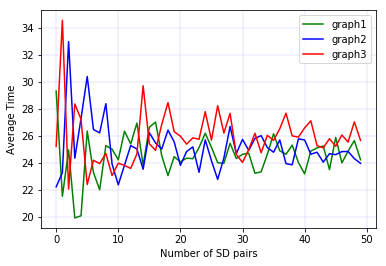

In [81]:
plt.plot(avg_edts1,color='green', label="graph1")
plt.plot(avg_edts2, color='blue', label="graph2")
plt.plot(avg_edts3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Average Time')
plt.legend()
plt.show()

### Plotting the distances for each number of source-destination pairs

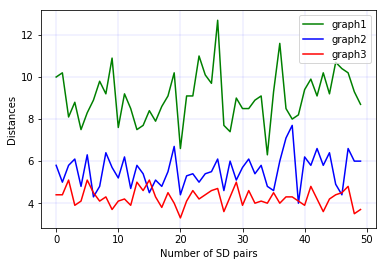

In [82]:
plt.plot(distances1,color='green', label="graph1")
plt.plot(distances2, color='blue', label="graph2")
plt.plot(distances3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Distances')
plt.legend()
plt.show()